<h1 style="color:blue; font-size:36px;">Projet Machine Learning 4A</h1>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso

In [3]:
data=pd.read_csv('global-data-on-sustainable-energy.csv')
data.shape
#data['Value_co2_emissions_kt_by_country'].groupby(['Entity'])
#data['Value_co2_emissions_kt_by_country'].groupby(data['Entity']).sum().sort_values(ascending=False)
data.isna().sum().sum()


6978

### <span style="color:blue">**I. Nettoyage des données** </span>

#### <span style="color:blue">**I.1 Suppression des NAN** </span>

In [4]:
data.shape

(3649, 21)

#### Grace à la statistique "count", nous constatons que les variables n'ont pas toutes le meme nombre d'observations indinquant ainsi la présence de données manquantes

In [5]:
(data.isna().sum()/data.shape[0]*100).sort_values(ascending=False)

Renewables (% equivalent primary energy)                            58.563990
Financial flows to developing countries (US $)                      57.248561
Renewable-electricity-generating-capacity-per-capita                25.513839
Value_co2_emissions_kt_by_country                                   11.729241
gdp_growth                                                           8.687312
gdp_per_capita                                                       7.728145
Energy intensity level of primary energy (MJ/$2017 PPP GDP)          5.672787
Renewable energy share in the total final energy consumption (%)     5.316525
Access to clean fuels for cooking                                    4.631406
Electricity from nuclear (TWh)                                       3.453001
Low-carbon electricity (% electricity)                               1.151000
Electricity from renewables (TWh)                                    0.575500
Electricity from fossil fuels (TWh)                             

#### Nous allons retirer les variables Renewables, Financial flows to developing countries et Renewable-electricity-generating-capacity-per-capita en raison de leur taux de données manquantes, situé entre 25 et 60 %. Ensuite, nous éliminerons tous les individus ayant des valeurs non disponibles (NaN) pour les variables restantes. il nous reste ainsi 2868 individus avec 18 variables

In [6]:
data.drop(['Renewable-electricity-generating-capacity-per-capita','Financial flows to developing countries (US $)','Renewables (% equivalent primary energy)'],axis=1,inplace=True)

In [7]:
data.shape

(3649, 18)

In [8]:
data.dropna(axis=0,inplace=True)
data.shape

(2868, 18)

#### <span style="color:blue">**I.2 Conversion des variables 'Year' et 'Entity'* </span>

In [9]:
data['Year'] = data['Year'].astype('category')
data.rename(columns={data.columns[14]: 'Density'}, inplace=True)#renommer la colonne Density pour faciliter l'accés à la variable
data['Density']=data['Density'].str.replace(',','')
data['Density']= pd.to_numeric(data['Density'], errors='coerce')

data.dtypes

Entity                                                                object
Year                                                                category
Access to electricity (% of population)                              float64
Access to clean fuels for cooking                                    float64
Renewable energy share in the total final energy consumption (%)     float64
Electricity from fossil fuels (TWh)                                  float64
Electricity from nuclear (TWh)                                       float64
Electricity from renewables (TWh)                                    float64
Low-carbon electricity (% electricity)                               float64
Primary energy consumption per capita (kWh/person)                   float64
Energy intensity level of primary energy (MJ/$2017 PPP GDP)          float64
Value_co2_emissions_kt_by_country                                    float64
gdp_growth                                                           float64

In [10]:
Value_co2_emissions_kt_by_country=data['Value_co2_emissions_kt_by_country']
data.drop(['Value_co2_emissions_kt_by_country'],axis=1,inplace=True)


In [11]:
data.drop(['Electricity from fossil fuels (TWh)'],axis=1,inplace=True)
data.isna().sum().sum()


0

### <span style="color:blue">**II. Analyse unidimentionnelle** </span>

#### <span style="color:blue">*II.1 Variables qualitatives* </span>

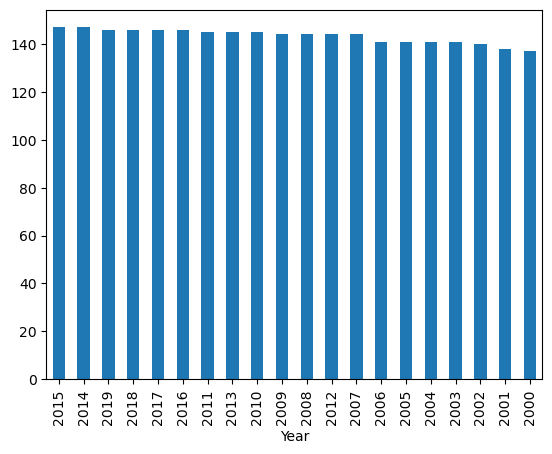

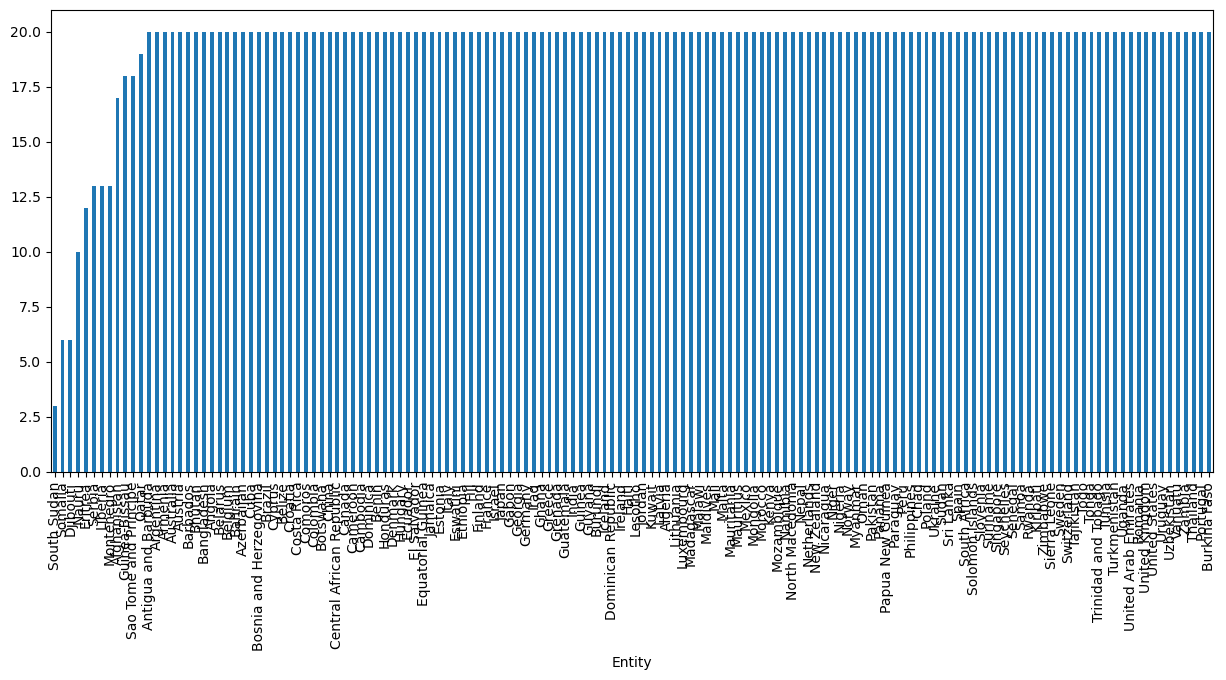

In [12]:
data['Year'].value_counts().plot.bar()
plt.figure(figsize=(15,6))

data['Entity'].value_counts().sort_values(ascending=True).plot.bar()
plt.tick_params(axis='x', rotation=90)

#### Nous observons des disparités dans le nombre d'observations pour chaque année. Les années les plus anciennes présentent moins d'observations que les plus récentes, ce qui peut indiquer une amélioration dans la collecte des données au fil du temps. De plus, il est important de noter que nous n'avons pas le même nombre d'observations pour chaque pays. Certains pays, comme le South Sudan, ont significativement moins d'observations par rapport aux autres, ce qui pourrait refléter des lacunes dans la disponibilité des données ou des déficultés dans la collecte d'informations dans ces régions

#### <span style="color:blue">*II.2 Variables quantitatives* </span>

NameError: name 'data1' is not defined

In [14]:
data1=data.iloc[:,2:] #On extrait que les variables quantitatives
print(type(data1))

<class 'pandas.core.frame.DataFrame'>


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'Access to electricity (% of population)'),
  Text(1, 0, 'Access to clean fuels for cooking'),
  Text(2, 0, 'Renewable energy share in the total final energy consumption (%)'),
  Text(3, 0, 'Electricity from nuclear (TWh)'),
  Text(4, 0, 'Electricity from renewables (TWh)'),
  Text(5, 0, 'Low-carbon electricity (% electricity)'),
  Text(6, 0, 'Primary energy consumption per capita (kWh/person)'),
  Text(7, 0, 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)'),
  Text(8, 0, 'gdp_growth'),
  Text(9, 0, 'gdp_per_capita'),
  Text(10, 0, 'Density'),
  Text(11, 0, 'Land Area(Km2)'),
  Text(12, 0, 'Latitude'),
  Text(13, 0, 'Longitude')])

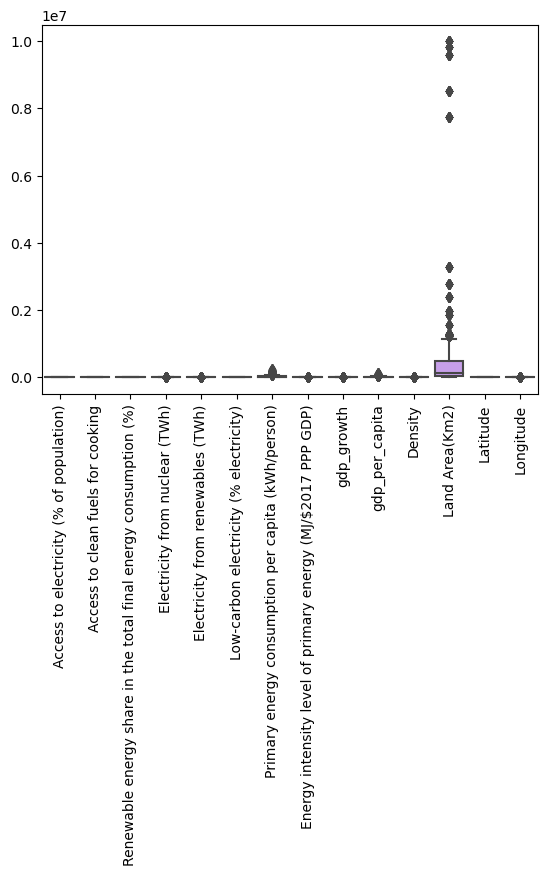

In [15]:
sns.boxplot(data1)
plt.xticks(rotation=90)

#### Nous notons que nos variables présentent non seulement  unités de mesure variées, mais aussi des échelles différentes. Certaines variables ont une importance relative plus élevée que d'autres. Afin d'homogénéiser nos données on va les centrer et les reduire

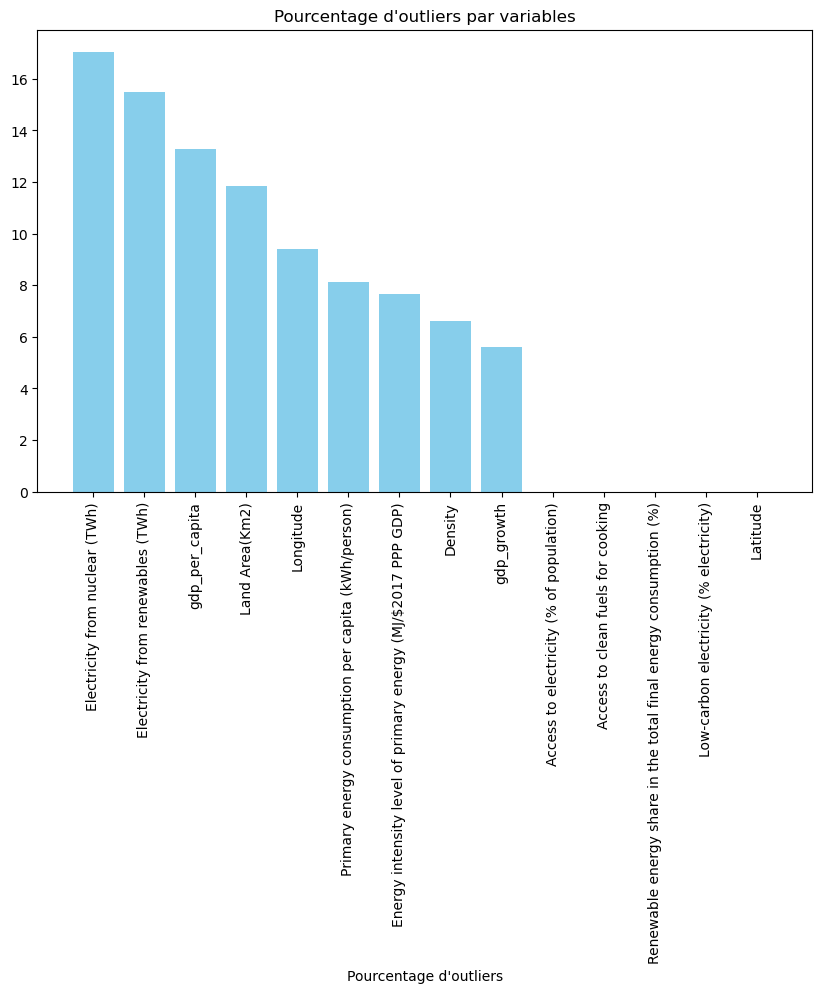

In [16]:

def percent_outliers(data):
    percent_outliers_list = []
    for i in range(data.shape[1]): 
            q1 = np.percentile(data.iloc[:, i], 25)
            q3 = np.percentile(data.iloc[:, i], 75)
            iqr = q3 - q1
            bornes_inf = q1 - 1.5 * iqr
            bornes_sup = q3 + 1.5 * iqr
            outliers = data.iloc[:, i][(data.iloc[:, i] < bornes_inf) | (data.iloc[:, i] > bornes_sup)]
            percent_outliers = 100 * len(outliers) / len(data.iloc[:, i])
            percent_outliers_list.append((data.columns[i], percent_outliers))
    return percent_outliers_list

pourcentages_outliers = percent_outliers(data1)

# Tri de la liste par ordre croissant en fonction du pourcentage d'outliers
pourcentages_outliers_tries = sorted(pourcentages_outliers, key=lambda x: x[1],reverse=True)


# Séparation des colonnes et des pourcentages
colonnes = [colonne for colonne, _ in pourcentages_outliers_tries]
pourcentages = [pourcentage for _, pourcentage in pourcentages_outliers_tries]

# Tracé du graphique à barres
plt.figure(figsize=(10, 6))
plt.bar(colonnes, pourcentages, color='skyblue')
plt.xlabel("Pourcentage d'outliers")
plt.title("Pourcentage d'outliers par variables")
plt.xticks(rotation=90)
plt.show()
        
    






On remarque après analyse des boxplot qu’il y'a beacoup d'outliers au niveau des variables 'Electricity from fossil fuels', 'Electricity from nuclear' et 'Electricity from renewables'. Il contiennent plus 15% de valeurs aberrantes. Il est plausible que dans certains pays, ces sources d'énergie soient très abondantes et largement utilisées, ce qui peut entraîner des fluctuations extrêmes dans les données.

IndexError: single positional indexer is out-of-bounds

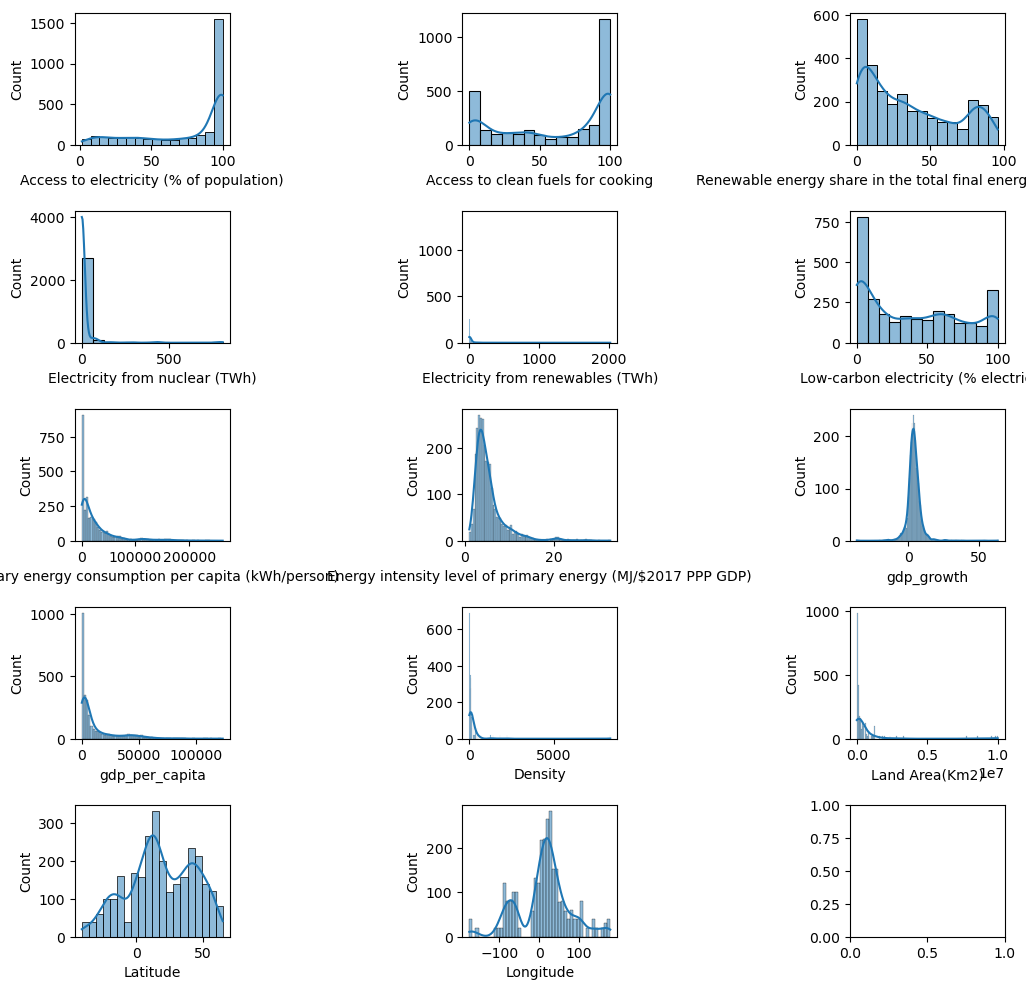

In [17]:
fig,ax=plt.subplots(5,3,figsize=(12, 12))
plt.subplots_adjust(wspace=1.5,hspace=0.5)
k=0
for i in range(5):
    for j in range(3):
        sns.histplot(data1.iloc[:, k], kde=True, ax=ax[i, j])
        k+=1

plt.show()


### <span style="color:blue">**II. Analyse multiimentionnelle** </span>

<Axes: >

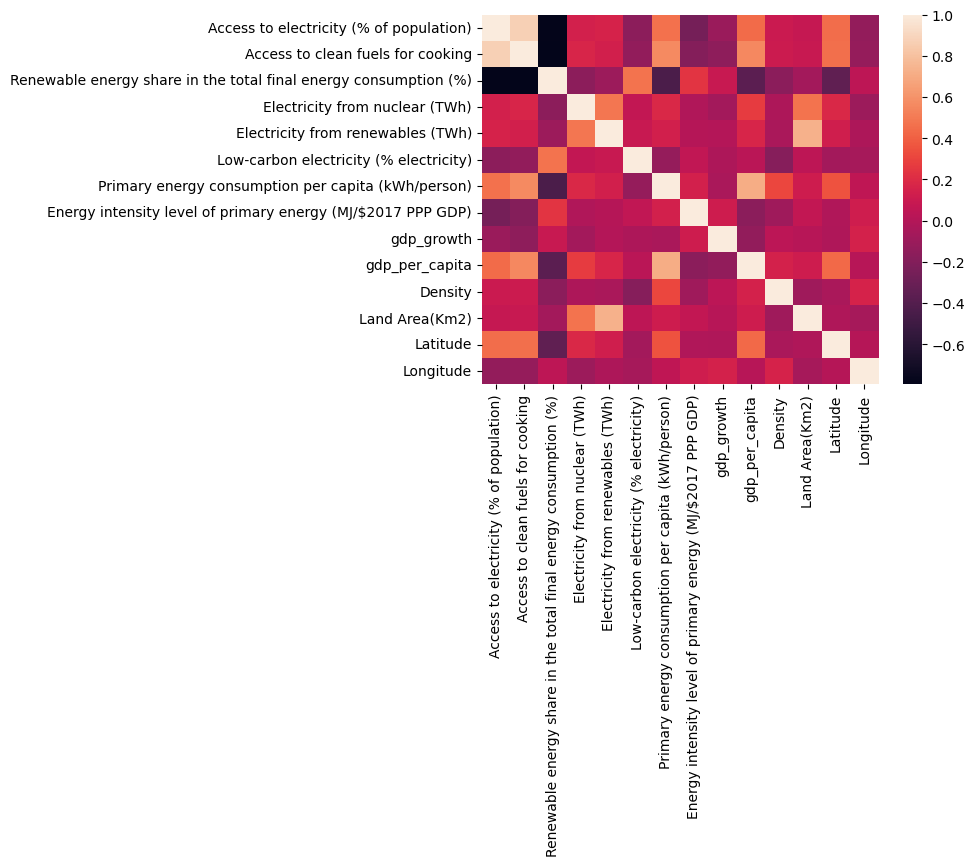

In [18]:
sns.heatmap(data1.corr())


In [19]:
correlation_matrix = np.corrcoef(data1, rowvar=False)


[['Access to electricity (% of population)', 'Access to clean fuels for cooking']]


IndexError: list index out of range

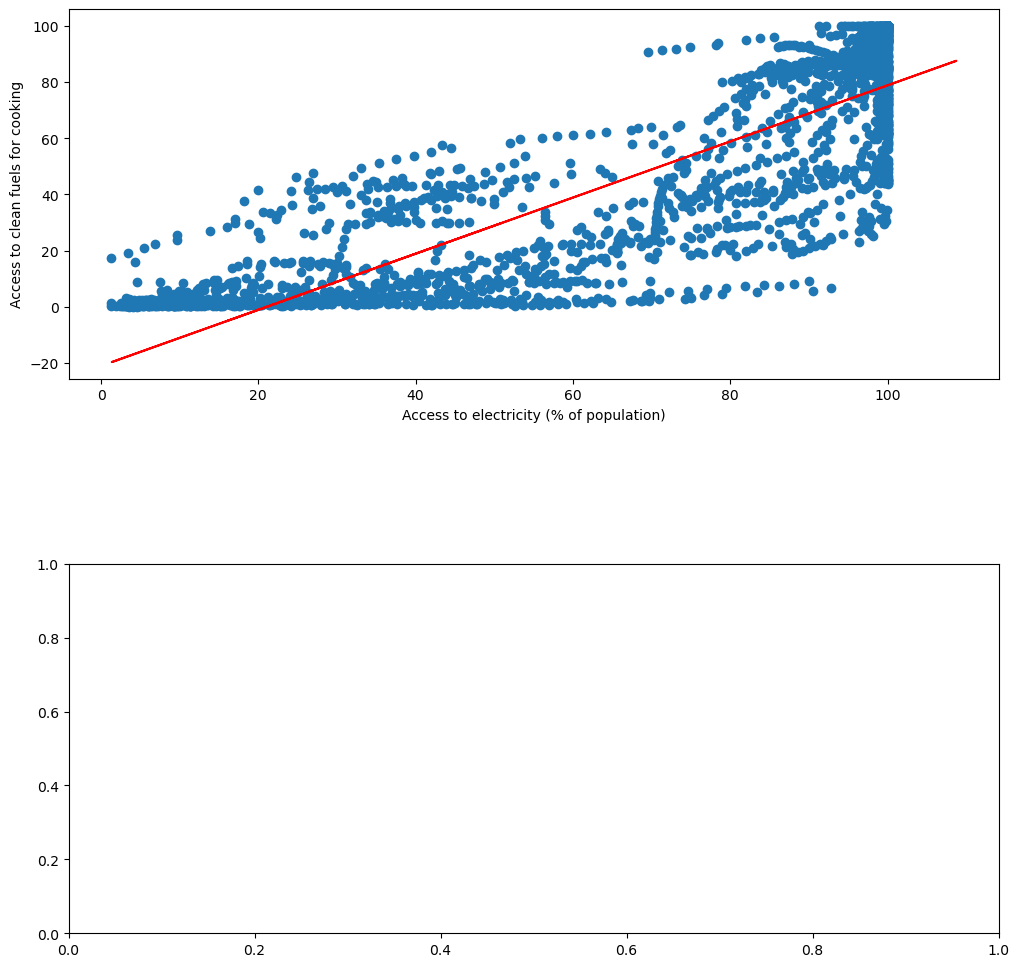

In [20]:

from scipy.stats import linregress
res=[]
for i in range(len(correlation_matrix)):
    for j in range(i+1, len(correlation_matrix)):
        correlation_coef = correlation_matrix[i, j]
        if correlation_coef > 0.8:
            res.append([data1.columns[i],data1.columns[j]])
print(res)

k=0
fig,ax=plt.subplots(2,1,figsize=(12,12))
plt.subplots_adjust(wspace=1.5,hspace=0.5)
j=1
for i in range(2):
        # Tracer le nuage de points
        ax[i].scatter(data1.loc[:, res[k][0]], data1.loc[:, res[k][1]])
    
        # Calcul de la droite de régression linéaire
        slope, intercept, _, _, _ = linregress(data1.loc[:, res[k][0]], data1.loc[:, res[k][1]])
        regression_line = slope * data1.loc[:, res[k][0]] + intercept
    
        # Tracer la droite de régression linéaire
        ax[i].plot(slope * data1.loc[:, res[k][0]], regression_line, color='red')
        # Étiquettes et légendes
        ax[i].set_xlabel(res[k][0])
        ax[i].set_ylabel(res[k][1])
        k+=1
        
        # Afficher le graphique
plt.show()

In [ ]:
len(res)

In [21]:
res

[['Access to electricity (% of population)',
  'Access to clean fuels for cooking']]

In [22]:
res=[]
for i in range(len(correlation_matrix)):
    for j in range(i+1, len(correlation_matrix)):
        correlation_coef = correlation_matrix[i, j]
        if correlation_coef > 0.8:
            res.append([data1.columns[i],data1.columns[j]])
print(res)
len(res)

[['Access to electricity (% of population)', 'Access to clean fuels for cooking']]


1

IndexError: single positional indexer is out-of-bounds

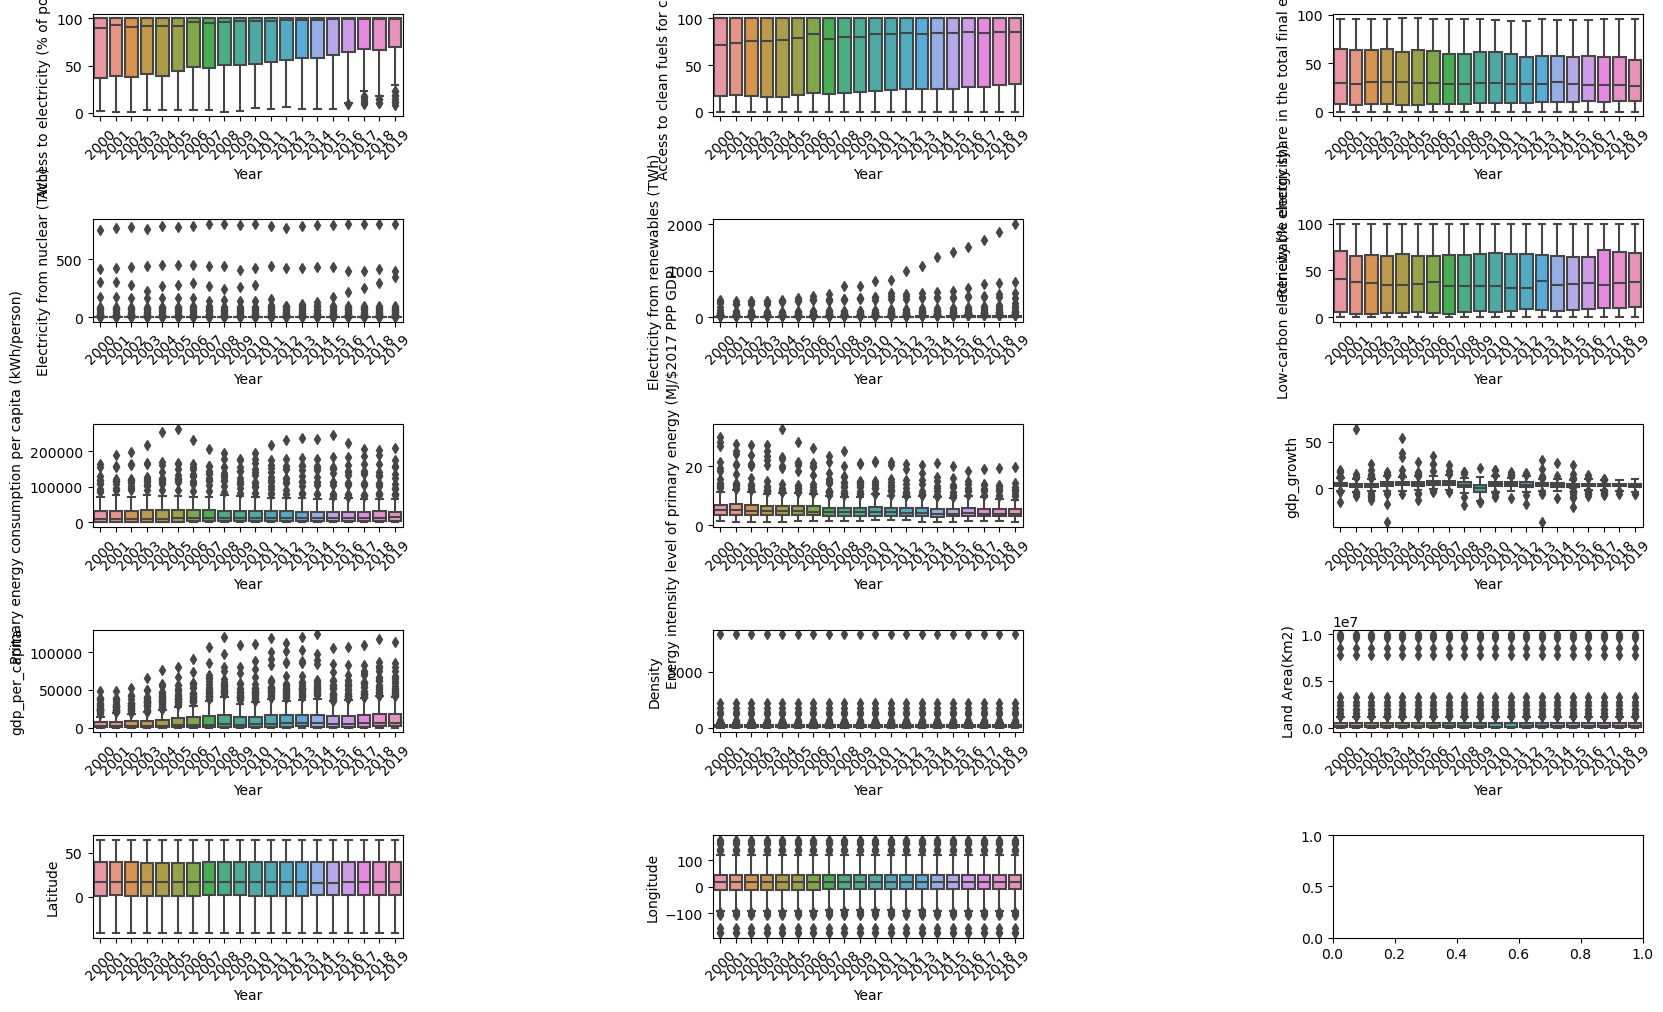

In [23]:
fig,ax=plt.subplots(5,3,figsize=(20,12))
plt.subplots_adjust(hspace=1, wspace=1)
k=0
for i in range(5):
    for j in range(3):
        sns.boxplot(x=data.iloc[:,1],y=data1.iloc[:,k],data=data,ax=ax[i, j])
        ax[i, j].set_xticks(ax[i, j].get_xticks())
        ax[i, j].set_xticklabels(ax[i, j].get_xticklabels(), rotation=45)
        k+=1
plt.show()

In [27]:
data.head()

,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable energy share in the total final energy consumption (%),Electricity from nuclear (TWh),Electricity from renewables (TWh),Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),gdp_growth,gdp_per_capita,Density,Land Area(Km2),Latitude,Longitude
3,Afghanistan,2003,14.738506,9.50,36.66,0.0,0.63,67.021280,229.96822,1.40,8.832278,190.683814,60,652230.0,33.93911,67.709953
4,Afghanistan,2004,20.064968,10.90,44.24,0.0,0.56,62.921350,204.23125,1.20,1.414118,211.382074,60,652230.0,33.93911,67.709953
5,Afghanistan,2005,25.390894,12.20,33.88,0.0,0.59,63.440857,252.06912,1.41,11.229715,242.031313,60,652230.0,33.93911,67.709953
6,Afghanistan,2006,30.718690,13.85,31.89,0.0,0.64,76.190475,304.42090,1.50,5.357403,263.733602,60,652230.0,33.93911,67.709953
7,Afghanistan,2007,36.051010,15.30,28.78,0.0,0.75,78.947370,354.27990,1.53,13.826320,359.693158,60,652230.0,33.93911,67.709953


In [28]:
mean=data1.mean()
std=data1.std()

data1=(data1-mean)/std

data1.head()


,Access to electricity (% of population),Access to clean fuels for cooking,Renewable energy share in the total final energy consumption (%),Electricity from nuclear (TWh),Electricity from renewables (TWh),Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),gdp_growth,gdp_per_capita,Density,Land Area(Km2),Latitude,Longitude
3,-1.962723,-1.342305,0.028575,-0.194691,-0.241298,0.795007,-0.696880,-1.123188,1.062713,-0.661295,-0.226595,-0.003482,0.63385,0.83599
4,-1.793684,-1.306625,0.281039,-0.194691,-0.241948,0.676013,-0.697574,-1.179095,-0.534097,-0.660190,-0.226595,-0.003482,0.63385,0.83599
5,-1.624663,-1.273495,-0.064018,-0.194691,-0.241670,0.691091,-0.696285,-1.120393,1.578777,-0.658553,-0.226595,-0.003482,0.63385,0.83599
6,-1.455582,-1.231444,-0.130298,-0.194691,-0.241205,1.061129,-0.694873,-1.095235,0.314722,-0.657395,-0.226595,-0.003482,0.63385,0.83599
7,-1.286358,-1.194491,-0.233882,-0.194691,-0.240183,1.141144,-0.693529,-1.086849,2.137714,-0.652272,-0.226595,-0.003482,0.63385,0.83599


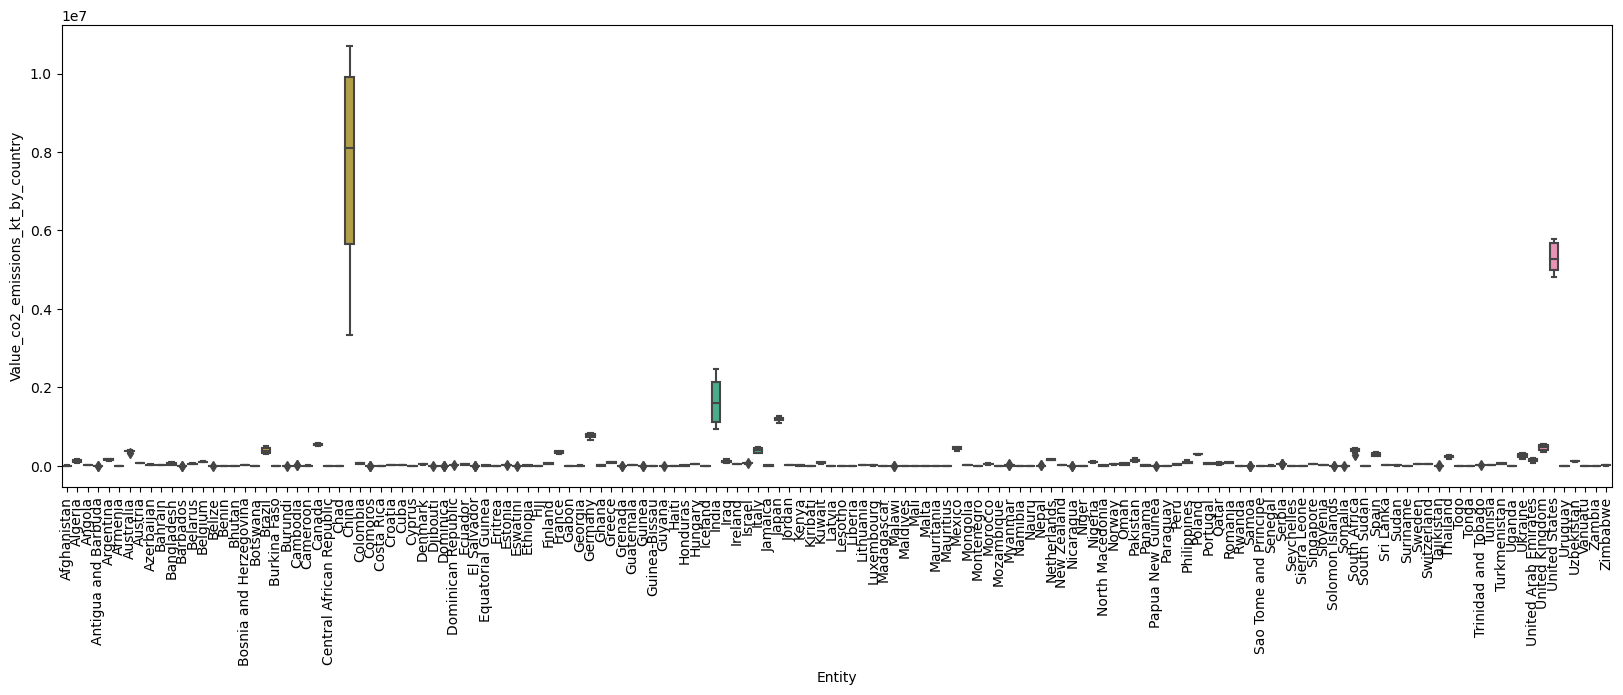

In [29]:
plt.figure(figsize=(20,6))
sns.boxplot(x=data['Entity'],y=Value_co2_emissions_kt_by_country,data=data)
plt.xticks(rotation=90)
plt.show()

Les 5 pays les plus émetteurs de CO2 sont: La chine, les etats unis,l'inde, le japon et L'allmagne

In [30]:
data1.isna().sum(axis=0).sort_values(ascending=False)
pca=PCA()
new_var=pca.fit(data1).transform(data1)


In [31]:
data1.columns[11]

'Land Area(Km2)'

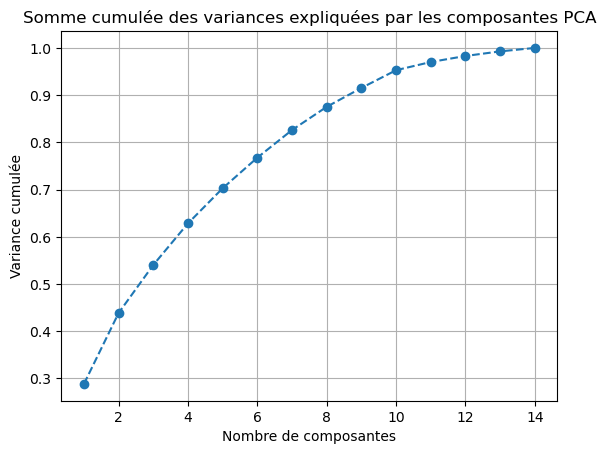

In [32]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Tracer la somme cumulée des variances
plt.plot(range(1, 15), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance cumulée')
plt.title('Somme cumulée des variances expliquées par les composantes PCA')
plt.grid(True)
plt.show()

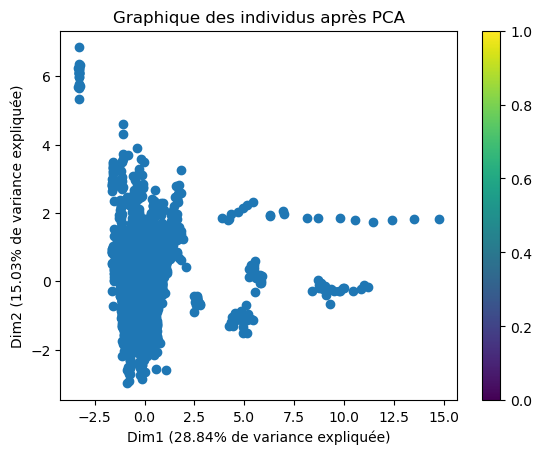

Index(['Access to electricity (% of population)',
       'Access to clean fuels for cooking',
       'Renewable energy share in the total final energy consumption (%)',
       'Electricity from nuclear (TWh)', 'Electricity from renewables (TWh)',
       'Low-carbon electricity (% electricity)',
       'Primary energy consumption per capita (kWh/person)',
       'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
       'gdp_growth', 'gdp_per_capita', 'Density', 'Land Area(Km2)', 'Latitude',
       'Longitude'],
      dtype='object')

In [33]:
plt.scatter(new_var[:,1],new_var[:,2])
plt.colorbar()
plt.xlabel(f'Dim1 ({pca.explained_variance_ratio_[0]*100:.2f}% de variance expliquée)')
plt.ylabel(f'Dim2 ({pca.explained_variance_ratio_[1]*100:.2f}% de variance expliquée)')
plt.title('Graphique des individus après PCA')
plt.show()
data1.columns

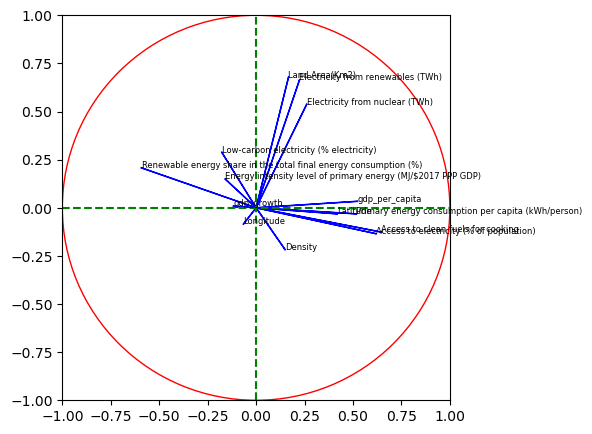

In [34]:
## coordonnées et représentation des variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[1])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[2])
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2,data1.columns):
     plt.text(i, j, nom,fontsize=6)
     plt.arrow(0,0,i,j,color='blue')

plt.axis((-1,1,-1,1))
plt.hlines(y=0,xmin=-1,xmax=1,linestyle='dashed',color='green')
plt.vlines(x=0,ymin=-1,ymax=1,linestyle='dashed',color='green')
# cercle
c=plt.Circle((0,0), radius=1, color='red', fill=False)
ax.add_patch(c)
plt.show()

# Premier modèle : régression linéaire simple

### Avec la méthode du lasso


In [35]:
# Splitting the data into training and testing sets
XTrain, XTest, YTrain, YTest = train_test_split(data1, Value_co2_emissions_kt_by_country, test_size=0.2, random_state=22)

# Scaling the features
scaler = StandardScaler()
scaler.fit(XTrain)
Xr_train = scaler.transform(XTrain)
Xr_test = scaler.transform(XTest)

# Fitting the Lasso regression model
regLasso = Lasso()
regLasso.fit(Xr_train, YTrain)

# Making predictions on the testing set
prev = regLasso.predict(Xr_test)

# Calculating mean squared error
mse = mean_squared_error(YTest, prev)
print("MSE =", mse)

MSE = 129608053661.51282


In [52]:
from sklearn.model_selection import GridSearchCV
# grille de valeurs du paramètre alpha à optimiser
param=[{"alpha":[0,0.05,0.1,0.2,0.3,50,500,1000,1500]}]
regLasso = GridSearchCV(linear_model.Lasso(), param,cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(Xr_train, YTrain)
# paramètre optimal
regLassOpt.best_params_["alpha"]
print("Meilleur R2 = %f, Meilleur paramètre = %s" % (regLassOpt.best_score_,regLassOpt.best_params_))

Meilleur R2 = 0.800507, Meilleur paramètre = {'alpha': 1500}


In [53]:
from sklearn.metrics import r2_score
prev=regLassOpt.predict(Xr_test)
print("MSE=",mean_squared_error(prev,YTest))
print("R2=",r2_score(YTest,prev))
#Le modèle est sur paramétré avec 20

MSE= 129555503860.63528
R2= 0.8052654911605999


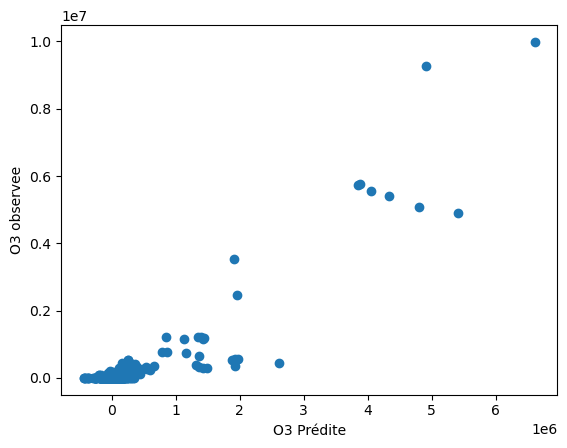

In [54]:
plt.plot(prev,YTest,"o")
plt.xlabel(u"O3 Prédite")
plt.ylabel("O3 observee")
plt.show()

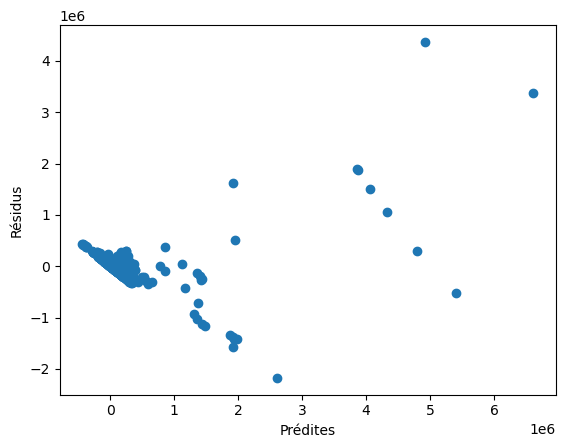

In [55]:
plt.plot(prev,YTest-prev,"o")
plt.xlabel(u"Prédites")
plt.ylabel(u"Résidus")
plt.hlines(0,40,220)
plt.show()

In [56]:
A=Value_co2_emissions_kt_by_country.mean()

In [57]:
# Dénombrement des erreurs par
# matrice de confusion
table=pd.crosstab(prev>A,YTest>A)
print(table)

Value_co2_emissions_kt_by_country  False  True 
row_0                                          
False                                445      8
True                                  55     66


In [58]:

print("Intercept:", regLassOpt.best_estimator_.intercept_)
print("Coefficients:", regLassOpt.best_estimator_.coef_)

Intercept: 167531.18105548318
Coefficients: [ 50013.39410711 -84753.08734509 -49726.58992257 202625.98149399
 623723.07773922 -96377.74280572 -50607.93751038  39393.21572371
  18875.37583661 -17062.76146524   5398.15559741     -0.
   1201.45139432  58740.45126137]


In [59]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [60]:
model.fit(XTest, YTest)

LinearRegression()

In [61]:
predicted_y = model.predict(XTest)

In [62]:
print("MSE=",mean_squared_error(predicted_y,YTest))
print("R2=",r2_score(YTest,predicted_y))

MSE= 115551798498.2982
R2= 0.8263144208039122


In [51]:
import statsmodels.api as sm
import itertools

# Créez une fonction pour ajuster un modèle avec une certaine combinaison de variables
def fit_model(features):
    X_subset = sm.add_constant(XTrain[list(features)])  # Sélectionnez toutes les colonnes de XTrain
    model = sm.OLS(YTrain, X_subset)
    result = model.fit()
    return result

best_bic = float('inf')  # Initialisation du BIC le plus bas
best_model = None  # Initialisation du meilleur modèle
best_features = None  # Initialisation des meilleures variables

# Liste de toutes les colonnes de XTrain
all_features = XTrain.columns.tolist()

# Boucle à travers toutes les combinaisons de variables possibles
for k in range(1, len(all_features) + 1):  # Essayer des modèles avec 1, 2, ..., N variables
    for combo in itertools.combinations(all_features, k):
        result = fit_model(combo)
        bic = result.bic
        if bic < best_bic:
            best_bic = bic
            best_model = result
            best_features = combo

# Affichage des résultats
print("Meilleur BIC :", best_bic)
print("Variables sélectionnées :", best_features)
print(best_model.summary())



Meilleur BIC : 65169.620160300554
Variables sélectionnées : ('Access to electricity (% of population)', 'Access to clean fuels for cooking', 'Renewable energy share in the total final energy consumption (%)', 'Electricity from nuclear (TWh)', 'Electricity from renewables (TWh)', 'Low-carbon electricity (% electricity)', 'Primary energy consumption per capita (kWh/person)', 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)', 'Longitude')
                                    OLS Regression Results                                   
Dep. Variable:     Value_co2_emissions_kt_by_country   R-squared:                       0.816
Model:                                           OLS   Adj. R-squared:                  0.815
Method:                                Least Squares   F-statistic:                     1126.
Date:                               Thu, 21 Mar 2024   Prob (F-statistic):               0.00
Time:                                       15:29:11   Log-Likelihood:        